In [1]:
# to verify if the spark context was initialized 
sc

In [2]:
#Import all the required packages

import numpy as np
import pandas as pd

from os import listdir
from os.path import join, basename
import struct
import json
from scipy import misc
import datetime as dt

from bigdl.nn.layer import *
from optparse import OptionParser
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.dataset.transformer import *
from bigdl.nn.initialization_method import *
from transformer import *
from imagenet import *
from transformer import Resize

# if you want to train on whole imagenet
#from bigdl.dataset import imagenet

In [3]:
#%pylab inline
%matplotlib inline 

## Model Definition and helper functions

In [4]:
# helper func to read the files from disk
def read_local_path(folder, has_label=True):
    # read directory, create map
    dirs = listdir(folder)
    print folder
    print dirs
    # create image path and label list
    image_paths = []
    print image_paths
    if has_label:
        dirs.sort()
        for d in dirs:
            for f in listdir(join(folder, d)):
                image_paths.append((join(join(folder, d), f), dirs.index(d) + 1))
    else:
        for f in dirs:
            image_paths.append((join(folder, f), -1))
    return image_paths

In [5]:
# helper func to read the files from disk
def read_local(sc, folder, normalize=255.0, has_label=True):
    """
    Read images from local directory
    :param sc: spark context
    :param folder: local directory
    :param normalize: normalization value
    :param has_label: whether the image folder contains label
    :return: RDD of sample
    """
    # read directory, create image paths list
    image_paths = read_local_path(folder, has_label)
    print image_paths
    # create rdd
    image_paths_rdd = sc.parallelize(image_paths)
    print image_paths_rdd
    feature_label_rdd = image_paths_rdd.map(lambda path_label: (misc.imread(path_label[0]), np.array(path_label[1]))) \
        .map(lambda img_label:
             (Resize(256, 256)(img_label[0]), img_label[1])) \
        .map(lambda feature_label:
             (((feature_label[0] & 0xff) / normalize).astype("float32"), feature_label[1]))
    return feature_label_rdd

The following function takes an input, if the input is a list, it insert into index 0 spot, such that the real data starts from index 1. Returns back a dictionary with key being the index and value the list of numbers.

In [6]:
def scala_T(input_T):
    
    if type(input_T) is list:
        # insert into index 0 spot, such that the real data starts from index 1
        temp = [0]
        temp.extend(input_T)
        return dict(enumerate(temp))
    # if dictionary, return it back
    return input_T

The following functions are used to create and initiate the inception-v1 model. 

In [7]:
def Inception_Layer_v1(input_size, config, name_prefix=""):
    
    
    '''
    Concat is a container who concatenates the output of it's submodules along the provided dimension: all submodules 
    take the same inputs, and their output is concatenated.
    '''
    concat = Concat(2)
    
    """
    In the above code, we first create a container Sequential. Then add the layers into the container one by one. The 
    order of the layers in the model is same with the insertion order. 
    
    """
    conv1 = Sequential()
    
    #Adding layes to the conv1 model we jus created
    
    #SpatialConvolution is a module that applies a 2D convolution over an input image.
    conv1.add(SpatialConvolution(input_size, config[1][1], 1, 1, 1, 1).set_name(name_prefix + "1x1"))
    conv1.add(ReLU(True).set_name(name_prefix + "relu_1x1"))
    concat.add(conv1)
    
    conv3 = Sequential()
    conv3.add(SpatialConvolution(input_size, config[2][1], 1, 1, 1, 1).set_name(name_prefix + "3x3_reduce"))
    conv3.add(ReLU(True).set_name(name_prefix + "relu_3x3_reduce"))
    conv3.add(SpatialConvolution(config[2][1], config[2][2], 3, 3, 1, 1, 1, 1).set_name(name_prefix + "3x3"))
    conv3.add(ReLU(True).set_name(name_prefix + "relu_3x3"))
    concat.add(conv3)
    
    
    conv5 = Sequential()
    conv5.add(SpatialConvolution(input_size,config[3][1], 1, 1, 1, 1).set_name(name_prefix + "5x5_reduce"))
    conv5.add(ReLU(True).set_name(name_prefix + "relu_5x5_reduce"))
    conv5.add(SpatialConvolution(config[3][1], config[3][2], 5, 5, 1, 1, 2, 2).set_name(name_prefix + "5x5"))
    conv5.add(ReLU(True).set_name(name_prefix + "relu_5x5"))
    concat.add(conv5)
    
    
    pool = Sequential()
    pool.add(SpatialMaxPooling(3, 3, 1, 1, 1, 1, to_ceil=True).set_name(name_prefix + "pool"))
    pool.add(SpatialConvolution(input_size, config[4][1], 1, 1, 1, 1).set_name(name_prefix + "pool_proj"))
    pool.add(ReLU(True).set_name(name_prefix + "relu_pool_proj"))
    concat.add(pool).set_name(name_prefix + "output")
    return concat

In [8]:
def Inception_v1(class_num):
    feature1 = Sequential()
    
    feature1.add(SpatialConvolution(3, 64, 7, 7, 2, 2, 3, 3, 1, False).set_name("conv1/7x7_s2"))
    feature1.add(ReLU(True).set_name("conv1/relu_7x7"))
    feature1.add(SpatialMaxPooling(3, 3, 2, 2, to_ceil=True).set_name("pool1/3x3_s2"))
    feature1.add(SpatialCrossMapLRN(5, 0.0001, 0.75).set_name("pool1/norm1"))
    feature1.add(SpatialConvolution(64, 64, 1, 1, 1, 1).set_name("conv2/3x3_reduce"))
    feature1.add(ReLU(True).set_name("conv2/relu_3x3_reduce"))
    feature1.add(SpatialConvolution(64, 192, 3, 3, 1, 1, 1, 1).set_name("conv2/3x3"))
    feature1.add(ReLU(True).set_name("conv2/relu_3x3"))
    feature1.add(SpatialCrossMapLRN(5, 0.0001, 0.75).set_name("conv2/norm2"))
    feature1.add(SpatialMaxPooling(3, 3, 2, 2, to_ceil=True).set_name("pool2/3x3_s2"))
    feature1.add(Inception_Layer_v1(192,scala_T([scala_T([64]), scala_T([96, 128]),scala_T([16, 32]), scala_T([32])]),
                                    "inception_3a/"))
    feature1.add(Inception_Layer_v1(256, scala_T([scala_T([128]), scala_T([128, 192]), scala_T([32, 96]), scala_T([64])]),
                                    "inception_3b/"))
    feature1.add(SpatialMaxPooling(3, 3, 2, 2, to_ceil=True).set_name("pool3/3x3_s2"))
    feature1.add(Inception_Layer_v1(480, scala_T([scala_T([192]), scala_T([96, 208]), scala_T([16, 48]), scala_T([64])]),
                                    "inception_4a/"))

    output1 = Sequential()
    output1.add(SpatialAveragePooling(5, 5, 3, 3, ceil_mode=True).set_name("loss1/ave_pool"))
    output1.add(SpatialConvolution(512, 128, 1, 1, 1, 1).set_name("loss1/conv"))
    output1.add(ReLU(True).set_name("loss1/relu_conv"))
    output1.add(View([128 * 4 * 4], num_input_dims = 3))
    output1.add(Linear(128 * 4 * 4, 1024).set_name("loss1/fc"))
    output1.add(ReLU(True).set_name("loss1/relu_fc"))
    output1.add(Dropout(0.7).set_name("loss1/drop_fc"))
    output1.add(Linear(1024, class_num).set_name("loss1/classifier"))
    output1.add(LogSoftMax().set_name("loss1/loss"))

    
    feature2 = Sequential()
    feature2.add(Inception_Layer_v1(512, scala_T([scala_T([160]), scala_T([112, 224]),scala_T([24, 64]), scala_T([64])]),
                                    "inception_4b/"))
    feature2.add(Inception_Layer_v1(512, scala_T([scala_T([128]), scala_T([128, 256]),scala_T([24, 64]), scala_T([64])]),
                                    "inception_4c/"))
    feature2.add(Inception_Layer_v1(512, scala_T([scala_T([112]), scala_T([144, 288]), scala_T([32, 64]), scala_T([64])]),
                                    "inception_4d/"))

    output2 = Sequential()
    output2.add(SpatialAveragePooling(5, 5, 3, 3).set_name("loss2/ave_pool"))
    output2.add(
        SpatialConvolution(528, 128, 1, 1, 1, 1).set_name("loss2/conv"))
    output2.add(ReLU(True).set_name("loss2/relu_conv"))
    output2.add(View([128 * 4 * 4], num_input_dims=3))
    output2.add(Linear(128 * 4 * 4, 1024).set_name("loss2/fc"))
    output2.add(ReLU(True).set_name("loss2/relu_fc"))
    output2.add(Dropout(0.7).set_name("loss2/drop_fc"))
    output2.add(Linear(1024, class_num).set_name("loss2/classifier"))
    output2.add(LogSoftMax().set_name("loss2/loss"))

    output3 = Sequential()
    output3.add(Inception_Layer_v1(528, scala_T([scala_T([256]), scala_T([160, 320]), scala_T([32, 128]), scala_T([128])]),
                                   "inception_4e/"))
    output3.add(SpatialMaxPooling(3, 3, 2, 2, to_ceil=True).set_name("pool4/3x3_s2"))
    output3.add(Inception_Layer_v1(832, scala_T([scala_T([256]), scala_T([160, 320]), scala_T([32, 128]), scala_T([128])]),
                                   "inception_5a/"))
    output3.add(Inception_Layer_v1(832,scala_T([scala_T([384]), scala_T([192, 384]),scala_T([48, 128]), scala_T([128])]),
                                   "inception_5b/"))
    output3.add(SpatialAveragePooling(7, 7, 1, 1).set_name("pool5/7x7_s1"))
    output3.add(Dropout(0.4).set_name("pool5/drop_7x7_s1"))
    output3.add(View([1024], num_input_dims=3))
    output3.add(Linear(1024, class_num).set_name("loss3/classifier"))
    output3.add(LogSoftMax().set_name("loss3/loss3"))

    split2 = Concat(2).set_name("split2")
    split2.add(output3)
    split2.add(output2)

    mainBranch = Sequential()
    mainBranch.add(feature2)
    mainBranch.add(split2)

    split1 = Concat(2).set_name("split1")
    split1.add(mainBranch)
    split1.add(output1)

    model = Sequential()

    model.add(feature1)
    model.add(split1)

    model.reset()
    return model

In [9]:
def get_inception_data(folder, file_type="image", data_type="train", normalize=255.0):
    #Getting the path of our data
    path = os.path.join(folder, data_type)
    if "seq" == file_type:
        #return imagenet.read_seq_file(sc, path, normalize) #-- incase if we are trying to read the orig imagenet data
        return read_seq_file(sc, path, normalize)
    elif "image" == file_type:
        #return imagenet.read_local(sc, path, normalize)
        return read_local(sc, path, normalize)

## Creating the model


In [10]:
# initializing BigDL engine
init_engine()

In [11]:
# paths for datasets, saving checkpoints 

DATA_PATH = "./sample/"
checkpoint_path = "./sample/checkpoints"

In [12]:
#providing the no of classes in the dataset to model
classNum = 1000 

# Instantiating the model the model
inception_model = Inception_v1(classNum)  #-- main inception-v1 model
#inception_model = Inception_v1_NoAuxClassifier(classNum)

creating: createSequential
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createSpatialCrossMapLRN
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialCrossMapLRN
creating: createSpatialMaxPooling
creating: createConcat
creating: createSequential
creating: createSpatialConvolution
creating: createReLU
creating: createSequential
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialConvolution
creating: createReLU
creating: createSequential
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialConvolution
creating: createReLU
creating: createSequential
creating: createSpatialMaxPooling
creating: createSpatialConvolution
creating: createReLU
creating: createConcat
creating: createSequential
creating: createSpatialConvolution
creating: createReLU
creating: createSequential
creating: createSpatialConvolutio

Download the pre-trained 'Inception v1 caffe model' from the link : https://github.com/BVLC/caffe/tree/master/models/bvlc_googlenet

In [13]:
# path, names of the downlaoded pre-trained caffe models
caffe_prototxt = 'bvlc_googlenet.prototxt'
caffe_model = 'bvlc_googlenet.caffemodel'

# loading the weights to the BigDL's inception model
model = Model.load_caffe(inception_model, caffe_prototxt, caffe_model, match_all=True, bigdl_type="float")

# if we want to export the whole caffe model including definition, this can be used.
#model = Model.load_caffe_model(inception_model, caffe_prototxt, caffe_model, match_all=True)

In [14]:
# forming a imagenet class dictionary 
fname = 'imagenet_class_index.json'
with open(fname) as f:
        class_dict = json.load(f)
        imagenet_classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

## Testing the pre-trained model

In [15]:
from PIL import Image
import cv2

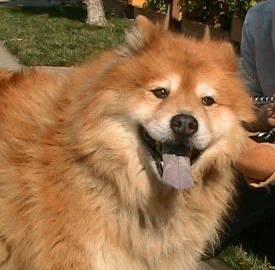

In [16]:
sample_images_path = "./sample_images/"
input_img = 'dog_2.jpg'
Image.open(sample_images_path + input_img)

In [17]:
# to read the data into numpy array
img = cv2.imread(sample_images_path + input_img)  
img.shape

(270, 275, 3)

In [18]:
# defining the tranformer, which we will use to pre-process our test image

img_rows = 224
img_cols = 224

transform_input = Transformer([Crop(img_rows, img_cols, "center"),
                                        Flip(0.5),
                                        ChannelNormalizer(0.485, 0.456, 0.406, 0.229, 0.224, 0.225),
                                        TransposeToTensor(False)
                                        ])

In [19]:
# pre-processing the image
img_tranx = transform_input(img)

In [20]:
# converting the image to 'Sample' format which the BigDL expects. For more about this check the Documentation
label = np.array(-1) #label is '-1' as its unknown to the model
img_to_model = Sample.from_ndarray(img_tranx, label)

In [21]:
# converting image from 'Sample' format into RDD format
img_data_rdd = sc.parallelize([img_to_model])

In [22]:
# prediciting the model
predict_result = model.predict_class(img_data_rdd)
pred_index = predict_result.collect()[0]

In [23]:
# printing out the category 
if pred_index > 999 :
    print ("not in the class list")
else:
    class_predicted = str(imagenet_classes[pred_index])
    print (class_predicted)

keeshond


## Fine-tuning the model

### To-do:
- pre-req : Define inception_v1 model in BigDL and load it with Caffe model's weights
- remove the last layer of the model)
- freeze all the layers 
- add a new layer with 'num_class' we have in our data-set
- compile the model

This concludes the fine-tuning process
#### next steps :
- train the model on our dataset ( you can use the code in the below sections "Traning the model for transfer learning ") 
- test the trained model on our test dataset 

## Traning the model for transfer learning 

In [ ]:
# reading the data and performing pre-processing 


# the image size expected by the model
image_size = 224

# image transformer, used for pre-processing the train images 
train_transformer = Transformer([Crop(image_size, image_size),
                                  Flip(0.5),
                                  ChannelNormalizer(0.485, 0.456, 0.406, 0.229, 0.224, 0.225),
                                  TransposeToTensor(False)])

# reading the traning data
train_data = get_inception_data(DATA_PATH, "image", "train").map(
                lambda features_label: (train_transformer(features_label[0]), features_label[1])).map(
                lambda features_label: Sample.from_ndarray(features_label[0], features_label[1] + 1))


# validation data transformer 
val_transformer = Transformer([Crop(image_size, image_size, "center"),
                                Flip(0.5),
                                ChannelNormalizer(0.485, 0.456, 0.406, 0.229, 0.224, 0.225),
                                TransposeToTensor(False)])

#reading the validation data
val_data = get_inception_data(DATA_PATH, "image", "val").map(
                lambda features_label: (val_transformer(features_label[0]), features_label[1])).map(
                lambda features_label: Sample.from_ndarray(features_label[0], features_label[1] + 1))



In [ ]:
# traning the model


# parameters for 
batch_size = 16
no_epochs = 2

# Optimizer
optimizer = Optimizer(
                model=inception_model,
                training_rdd=train_data,
                #optim_method=Adam(learningrate=0.002),
                optim_method = SGD(learningrate=0.01, learningrate_decay=0.0002),
                criterion=ClassNLLCriterion(),
                end_trigger=MaxEpoch(no_epochs),
                batch_size=batch_size
            )

# setting checkpoints
optimizer.set_checkpoint(EveryEpoch(), checkpoint_path, isOverWrite=False)

# setting validation parameters 
optimizer.set_validation( batch_size=batch_size,
                          val_rdd=val_data,
                          trigger=EveryEpoch(),
                          val_method=[Top1Accuracy()])

# traning the model
trained_model = optimizer.optimize()


In [ ]:
# testing our model on valid data
# todo : should tried with test data and modify the code accordingly

# image transformer, used for pre-processing the validation images 
test_transformer = Transformer([Crop(image_size, image_size, "center"),
                                Flip(0.5),
                                ChannelNormalizer(0.485, 0.456, 0.406, 0.229, 0.224, 0.225),
                                TransposeToTensor(False)])

# shouldn't the option to be passed is 'test' here rather than 'val' ? 
# reading val data 
test_data = get_inception_data(DATA_PATH, "image", "val").map(
                lambda features_label: (test_transformer(features_label[0]), features_label[1])).map(
                lambda features_label: Sample.from_ndarray(features_label[0], features_label[1] + 1))

'''
# Incase the model is alreay built and want to test it
# path to the saved model
model_path = "  "
model = Model.load(options.model)
results = model.test(test_data, batch_size, ["Top1Accuracy", "Top5Accuracy"])
'''

# testing the trained model 
results = trained_model.test(test_data, batch_size, ["Top1Accuracy", "Top5Accuracy"])

for result in results:
    print result

print ("---- the end -----")